
Outline so far:
1. Read in the data, set new col names
2. Engineer features
    2a. From NHANES, get mean FVC and FEV1 by age
    2b. Get interactions as in that Xu paper. What is the intuition behind them?
3. Select numeric cols
4. Fix strings, change F/T to 0/1
5. Encoding: Performance and Tumor_size to ordinal, DGN with OneHot
6. Split train/test
   6a. Balancing? Maybe up-sample the positive (dies) class? - need to do this on training fold ONLY while doing K-folds
   
7. Fit scaler to train, transform train/test

Seems LIME requires categorical features to be ints, with a mapping
from int to string for the actual name. Create that map early


In [10]:
import pandas as pd
import seaborn as sns

spirometry = pd.read_sas('SPX_G.XPT')
demographics = pd.read_sas('DEMO_G.XPT')
body = pd.read_sas('BMX_G.XPT')
enx = pd.read_sas('ENX_G.XPT')
bpx = pd.read_sas('BPX_G.XPT')

# 1 is male, 2 is female for sex
subset = spirometry[['SPXNFVC', 'SPXNFEV1', 'SEQN', 
                             'ENQ010', 'ENQ020', 'SPQ040', 'ENQ100', 
                             'SPQ050', 'SPQ060','SPQ070B', 'SPQ100']]
demographics = demographics[['RIDAGEYR', 'RIAGENDR', 'SEQN']]
body = body[['BMXHT', 'BMXWT', 'SEQN']]
enx = enx[['ENQ040','ENQ090','ENXTR4Q','SEQN']]
bpx = bpx[['BPQ150D','SEQN']]

subset = pd.merge(subset, demographics, 'left', 'SEQN')
subset = pd.merge(subset, body, 'left', 'SEQN')
subset = pd.merge(subset, enx, 'left', 'SEQN')
subset = pd.merge(subset, bpx, 'left', 'SEQN')
subset.rename(columns = {'SPXNFVC': 'FVC', 'SPXNFEV1': 'FEV1',
                        'RIDAGEYR': 'Age', 'RIAGENDR': 'Sex', 
                        'BMXHT': 'Height', 'BMXWT': 'Weight'}, inplace=True)

subset.columns

Index(['FVC', 'FEV1', 'SEQN', 'ENQ010', 'ENQ020', 'SPQ040', 'ENQ100', 'SPQ050',
       'SPQ060', 'SPQ070B', 'SPQ100', 'Age', 'Sex', 'Height', 'Weight',
       'ENQ040', 'ENQ090', 'ENXTR4Q', 'BPQ150D'],
      dtype='object')

In [3]:
# filter out entries where spirometry may be abnormal
# entries prior to filtering: 7495
subset = subset[subset['ENQ010'] !=1] # breathing problem requiring oxygen
#7454 entries
subset = subset[subset['ENQ020']!=1] # problem taking a deep breath
#7388 entries
subset = subset[subset['SPQ040']!=1] # chest/abdominal surgery ever
#6346 entries
subset = subset[subset['SPQ050']!=1] # chest abdominal surgery in last 3 months
#6346 entries
subset = subset[subset['SPQ060']!=1] # TB in last year
#6324 entries
subset = subset[subset['SPQ070B']!=2] # ever been told of a collapsed lung
#6295 entries
subset = subset[subset['SPQ100']!=1] # hemoptysis in past month
#6276 entries
subset = subset[subset['ENQ100']!=1] # respiratory illness in last 7 days
#5219 entries
subset = subset[subset['ENQ040']!=1] # smoked in the last hour
# 5073 entries
subset = subset[subset['ENQ090']!=1] # used oral/inhaled steroids within last 2 days (often used in asthma/COPD)
# remove missing values
subset.dropna(axis=0, subset=['FVC','Age','FVC'])
# 4950 entries
subset.shape[0]

4950

In [5]:
# Verified that there was still a decent number of each age. There was

#agecounts = dict(zip(subset.Age.unique(),subset.groupby('Age')['Age'].count().values))
#for key in sorted(agecounts):
#    print("%s: %s" % (key, agecounts[key]))

Most ages still have a decent number of reps

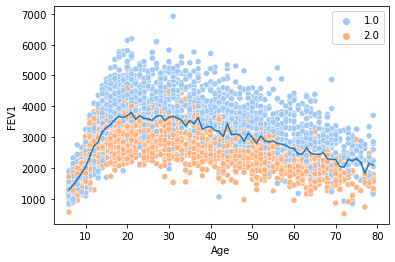

In [7]:
estimates = subset.groupby('Age')[['FVC', 'FEV1']].mean()
estimates.rename(columns={'FVC':'mean_FVC', 'FEV1':'mean_FEV1'}, inplace=True)

sns.scatterplot(x=subset['Age'], y=subset['FEV1'], hue=subset['Sex'], palette='pastel')
sns.lineplot(x=estimates.index.values, y=estimates['mean_FEV1'])

In [41]:
import pandas as pd

surgery = pd.read_csv('ThoracicSurgery.csv', index_col = 0)
surgery.rename(columns = {'DNG': 'Diagnosis', 'PRE4': 'FVC',
                            'PRE5': 'FEV1', 'PRE6': 'Performance',
                            'PRE7': 'Pain', 'PRE8': 'Haemoptysis',
                            'PRE9': 'Dyspnoea', 'PRE10': 'Cough',
                            'PRE11': 'Weakness', 'PRE14': 'Tumor_size',
                            'PRE17': 'Type2_diabetes', 'PRE19': 'MI_6months',
                            'PRE25': 'PAD', 'PRE30': 'Smoking',
                            'PRE32': 'Asthma', 'AGE': 'Age'}, inplace=True)

In [44]:
# Linear regression to extrapolate FVC and FEV1 values for patients
# older than 79 years
from sklearn.linear_model import LinearRegression
import numpy as np

lr_estimates = estimates[estimates.index > 25]
lr_FVC = LinearRegression(fit_intercept=True,normalize=True).fit(lr_estimates.index.values.reshape(-1, 1),lr_estimates['mean_FVC'])
lr_FEV1 = LinearRegression(fit_intercept=True,normalize=True).fit(lr_estimates.index.values.reshape(-1, 1),lr_estimates['mean_FEV1'])

pred_ages = np.arange(80,surgery.Age.max()+1).reshape(-1,1)
lr_estimates = pd.DataFrame([lr_FVC.predict(pred_ages).flatten(),lr_FEV1.predict(pred_ages).flatten()]).T
lr_estimates.columns = estimates.columns
lr_estimates.index = pred_ages.flatten()
estimates = estimates.append(lr_estimates)

# Impute erroneously high FEV1 values (greater than the patient's own FVC)
errs = surgery.loc[(surgery.FEV1 > surgery.FVC),:].index
for i in errs:
    patient = surgery.iloc[i,:]
    near_age = surgery.loc[(surgery.Age >= patient.Age-2) & (surgery.Age <= patient.Age+2),:]
    near_age = near_age.loc[~near_age.index.isin(test.index)]
    surgery.loc[i,'FEV1'] = near_age.FEV1.mean()

In [45]:
surgery['FEV1/FVC'] = surgery['FEV1'] / surgery['FVC']
surgery['expected_FVC'] = estimates.loc[surgery.Age, 'mean_FVC'].values / 1000
surgery['expected_FEV1'] = estimates.loc[surgery.Age, 'mean_FEV1'].values / 1000
surgery['expected_FEV1/FVC'] = surgery['expected_FEV1'] / surgery['expected_FVC']
surgery['FVC_deficit'] = surgery['expected_FVC']-surgery['FVC']
surgery['FEV1_deficit'] = surgery['expected_FEV1']-surgery['FEV1']
surgery['FEV1/FVC_deficit'] = surgery['expected_FEV1/FVC']-surgery['FEV1/FVC']
surgery['FEV1^2'] = surgery['FEV1']**2
surgery['FVC^2'] = surgery['FVC']**2


surgery['Age*FVC'] = surgery['Age']*surgery['FVC']
surgery['Age*FEV1'] = surgery['Age']*surgery['FEV1']
surgery['FVC*FEV1'] = surgery['FVC']*surgery['FEV1']
surgery['FVC^2*FEV1'] = surgery['FEV1']*(surgery['FVC']**2)
surgery['FVC*FEV1^2'] = surgery['FVC']*(surgery['FEV1']**2)

surgery.drop(columns=['expected_FVC', 'expected_FEV1', 'expected_FEV1/FVC'], inplace=True)


surgery

,DGN,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,...,FVC_deficit,FEV1_deficit,FEV1/FVC_deficit,FEV1^2,FVC^2,Age*FVC,Age*FEV1,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2
0,b'DGN2',2.88,2.16,b'PRZ1',b'F',b'F',b'F',b'T',b'T',b'OC14',...,0.596967,0.450341,0.000752,4.6656,8.2944,172.80,129.60,6.2208,17.915904,13.436928
1,b'DGN3',3.40,1.88,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC12',...,0.221250,0.893609,0.212985,3.5344,11.5600,173.40,95.88,6.3920,21.732800,12.016960
2,b'DGN3',2.76,2.08,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',...,0.585841,0.464825,0.006970,4.3264,7.6176,162.84,122.72,5.7408,15.844608,11.940864
3,b'DGN3',3.68,3.04,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',...,-0.167704,-0.338963,-0.057064,9.2416,13.5424,198.72,164.16,11.1872,41.168896,34.009088
4,b'DGN3',2.44,0.96,b'PRZ2',b'F',b'T',b'F',b'T',b'T',b'OC11',...,0.400282,1.094231,0.329806,0.9216,5.9536,178.12,70.08,2.3424,5.715456,2.248704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,b'DGN2',3.88,2.12,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC13',...,-0.440600,0.418937,0.191800,4.4944,15.0544,244.44,133.56,8.2256,31.915328,17.438272
466,b'DGN3',3.76,3.12,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',...,-0.617076,-0.720367,-0.066284,9.7344,14.1376,229.36,190.32,11.7312,44.109312,36.601344
467,b'DGN3',3.04,2.08,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC13',...,0.523833,0.738667,0.106698,4.3264,9.2416,158.08,108.16,6.3232,19.222528,13.152256
468,b'DGN3',1.96,1.68,b'PRZ1',b'F',b'F',b'F',b'T',b'T',b'OC12',...,0.865938,0.273313,-0.165934,2.8224,3.8416,154.84,132.72,3.2928,6.453888,5.531904


In [29]:
# Select this right after engineering new features, but
# before changing F/T to 0/1
numeric_cols = surgery.select_dtypes('number').columns

In [83]:
# removing the b'' from strings
surgery.loc[:,surgery.dtypes=='object']= surgery.loc[:,surgery.dtypes=='object'].apply(lambda s: (s.str.replace("\'", "").str.replace('b', '')))
surgery

# Change F and T to 0 and 1
surgery.replace(to_replace = ['F', 'T'], value=[0,1], inplace=True)
surgery

In [8]:
# Now let's encode our categorical variables with integers, saving the map
# Definitely want to use Ordinal encoding for Performance and Tumor size
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
ord_cols = ['Performance', 'Tumor_size']

for col in ord_cols:
    surgery[col] = surgery[col].str.strip().str[-1].astype(int)
    
surgery = surgery[~(surgery.DGN.isin(['DGN1', 'DGN6', 'DGN8']))]
surgery = pd.get_dummies(surgery, prefix=[''], columns=['DGN'])
surgery

,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,Type2_diabetes,...,FVC^2,Age*FVC,Age*FEV1,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2,_DGN2,_DGN3,_DGN4,_DGN5
0,2.88,2.16,1,0,0,0,1,1,4,0,...,8.2944,172.80,129.60,6.2208,17.915904,13.436928,1,0,0,0
1,3.40,1.88,0,0,0,0,0,0,2,0,...,11.5600,173.40,95.88,6.3920,21.732800,12.016960,0,1,0,0
2,2.76,2.08,1,0,0,0,1,0,1,0,...,7.6176,162.84,122.72,5.7408,15.844608,11.940864,0,1,0,0
3,3.68,3.04,0,0,0,0,0,0,1,0,...,13.5424,198.72,164.16,11.1872,41.168896,34.009088,0,1,0,0
4,2.44,0.96,2,0,1,0,1,1,1,0,...,5.9536,178.12,70.08,2.3424,5.715456,2.248704,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,3.88,2.12,1,0,0,0,1,0,3,0,...,15.0544,244.44,133.56,8.2256,31.915328,17.438272,1,0,0,0
466,3.76,3.12,0,0,0,0,0,0,1,0,...,14.1376,229.36,190.32,11.7312,44.109312,36.601344,0,1,0,0
467,3.04,2.08,1,0,0,0,1,0,3,0,...,9.2416,158.08,108.16,6.3232,19.222528,13.152256,0,1,0,0
468,1.96,1.68,1,0,0,0,1,1,2,0,...,3.8416,154.84,132.72,3.2928,6.453888,5.531904,0,1,0,0


In [10]:
# Need to split train/test, then fit scaler on train and apply to both
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(surgery.drop('Risk1Yr', axis=1), 
                                                    surgery['Risk1Yr'], test_size=0.2,
                                                   random_state = 64)

scaler = StandardScaler()

# Fit the scalar on train only to prevent data leakage from test set
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

Text(0, 0.5, 'Count')

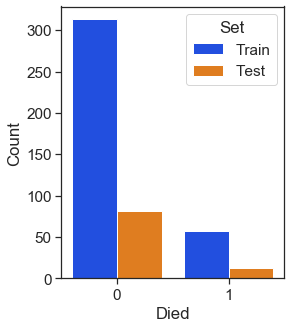

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()
y_train_2 = pd.DataFrame({'Died': y_train_2, 'Set': 'Train'})
y_test_2 = pd.DataFrame({'Died': y_test_2, 'Set': 'Test'})
df = pd.concat([y_train_2,y_test_2], axis=0)
df

fig = plt.figure(figsize=(4,5))
sns.set(font_scale = 1.4, style='ticks')
ax = sns.countplot(data=df, x='Died', hue='Set', palette='bright')
ax.set_xticks([0,1])
#ax.set_xlabel('Died',)
ax.set_ylabel('Count')
#ax.set_xticks(size=12)

<Figure size 576x360 with 0 Axes>

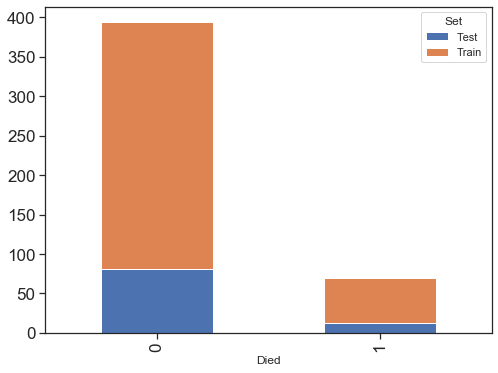

In [63]:
fig = plt.figure(figsize=(8,5))
kws_2=
kws = {'figsize': (8,6), 'fontsize': 17}

pd.crosstab(df['Died'], df['Set']).plot.bar(stacked=True, **kws) 